In [729]:
import csv
import pandas as pd
import numpy as np
#import filters  # THIS LIBRARY IS NOT INCLUDED IN THE REPOSITORY
import matplotlib.pyplot as pyp
import scipy.signal as signal
import numpy.fft as fft
import os         # ADD THIS SO WE CAN USE ENVIRONMENT VARIABLES
import matplotlib
from scipy.optimize import curve_fit
import scipy.optimize
from scipy.interpolate import interp1d
%matplotlib inline

#print os.environ
print os.environ.get('TAU_ACC_ZHAIRES_DIR')
#print os.environ['TAU_ACC_ZHAIRES_DIR']

/Users/wissels/Dropbox/MountainTop/harms_sims/npz_files/


In [730]:
pastel_colors = ['#FF6666','#FFCC66','#CCFF66','#66FF66','#66FFCC','#66FFFF','#66CCFF','#6666FF','#CC66FF','#FF66FF','#FF6FCF']
bright_colors = ['#FF0000','#FF8000','#FFFF00','#80FF00','#00FF00','#00FF80','#00FFFF','#0080FF','#0000FF','#8000FF','#FF00FF']
bright_colors2 = bright_colors = ['#FF0000','#FF8000','#80FF00','#00FF80','#0080FF','#0000FF','#8000FF','#FF00FF','#FF0080']
pyp.rcParams['font.size']=11
pyp.rcParams['legend.labelspacing'] = 0.1
cmap = matplotlib.cm.get_cmap('inferno')

In [731]:
#### Should move this to a library

In [732]:
def temp(f_MHz):
    # Dulk 2001
    nu = f_MHz # Hz
    tau = 5.0 * pow(nu, -2.1)
    Ieg = 1.0610e-20
    Ig  = 2.48e-20
    # Iv in  W/m^2/Hz/sr
    Iv = Ig * pow(nu, -0.52) * (1-np.exp(-tau))/tau + Ieg * pow(nu, -0.80) * np.exp(-tau)
    
    kB = 1.38064852e-23 # Watts / Hz / K
    c = 299792458 # m/s
    temp = Iv * c**2 / (2*(nu*1e6)**2)/kB

    return Iv, temp # W/m^2/Hz/sr, K

def read_npz_files(antenna_height, zenith):
    npzfile = np.load(os.environ['TAU_ACC_ZHAIRES_DIR'] + "/" + "altitude_%dkm_zenith_%d.npz"%(antenna_height, zenith))
    efield_td = npzfile['efield_td'][()] ## for some reason just reading the arrays gives a 0-dim array, so skip this.
    efield_fd = npzfile['efield_fd'][()]
    return efield_td, efield_fd

In [733]:
# WANT TO INTERPOLATE THE EFIELDS AT
# ALL ZENITH ANGLES, PSI ANGLES, and STARTING FREQUENCYS
# FOR 10-MHz SUBBANDS

def band_peak_efield(efield, freq, f_LO, bandwidth):
    df = freq[1]-freq[0]
    cut = np.logical_and(freq>=f_LO, freq<=f_LO + bandwidth)
    return np.sum(np.abs(efield[cut]))*df

def efield_vs_angle(h, z, f_Lo_list, bandwidth_list):

    off_angle_array = np.arange(0.04,80*0.04, 0.04)
    i_off_angle_array = range(1, len(off_angle_array)+1)
    epeak_list = np.zeros((len(f_Lo_list), len(bandwidth_list), len(i_off_angle_array)))
    cc = 0
    for i_offangle in i_off_angle_array:
        #if(i_offangle%10==0): print i_offangle
        offangle = off_angle_array[i_offangle-1]
        efield_td, efield_fd = read_npz_files(h,z)
        efield = efield_td[i_offangle]['y_v_per_m']
        time = efield_td[i_offangle]['time_s']
        time -= time[0]
        dt = time[1]-time[0]
        E_fft = np.fft.rfft(efield)*dt*1.e6 # use dt in µs so that fft is in units of V/m/MHz
        fr = np.fft.rfftfreq(len(efield), dt*1.e6) # frequencies in MHz
        for i_f_Lo in range(0,len(f_Lo_list)):
            f_Lo = f_Lo_list[i_f_Lo]
            for i_bandwidth in range(0,len(bandwidth_list)):
                bandwidth = bandwidth_list[i_bandwidth]
                epeak_list[i_f_Lo, i_bandwidth, cc] = band_peak_efield(E_fft, fr, f_Lo, bandwidth)
        cc+=1
    #pyp.figure(3)
    #pyp.plot(off_angle_array, voltage_SNR, 'ko')
    return off_angle_array, epeak_list

In [734]:
h = 37
zenith_list = np.array([60, 70, 75, 80, 85, 87])
f_Lo_list = np.arange(10., 1610., 10.)
bandwidth_list = np.array([10.])

###
# Construct an array of the peak efield for a range of starting frequencies
# and bandwidths and psi angles
## Shape of the array is 
##  [zenith angle [60,70,75,80,85, starting_frequency (10-1600 MHz in 10 MHz steps), bandwidth (10 MHz), off_angles (0.04-3.2 in 0.04 deg steps)]

epeak_array = []
for z in zenith_list:
    psi_list, epeak_list = efield_vs_angle(h, z, f_Lo_list, bandwidth_list)
    epeak_array.append(epeak_list)
    
epeak_array = np.array(epeak_array)


In [735]:
def epeak_zenith_angle_slice(i_ze, epeak_array):
    return epeak_array[i_ze,:,0,:] 
def epeak_start_freq_slice(i_f_Lo, epeak_array):
    return epeak_array[:,i_f_Lo,0,:] 
def epeak_psi_angle_slice(i_psi, epeak_array):
    return epeak_array[:,:,0,i_psi] 

###################################
 Let's see what we're up against
 By looking at heat maps of slices of the data
 
##################################

Dimensions of the data set include:

    + zenith angle (sparse, [60.70.75,80,85,87])
    + starting frequency (f_Lo) [10-1610 MHz in 10 Mhz steps]
    + bandwidth (bandwidth) [just 10 MHz, so single element array]
    + psi angle / view angle (0.04 to 3.2° in 0.04 steps)


In [736]:
print (len(zenith_list), len(f_Lo_list), len(bandwidth_list), len(psi_list))
print np.shape(epeak_array)

(6, 160, 1, 79)
(6, 160, 1, 79)


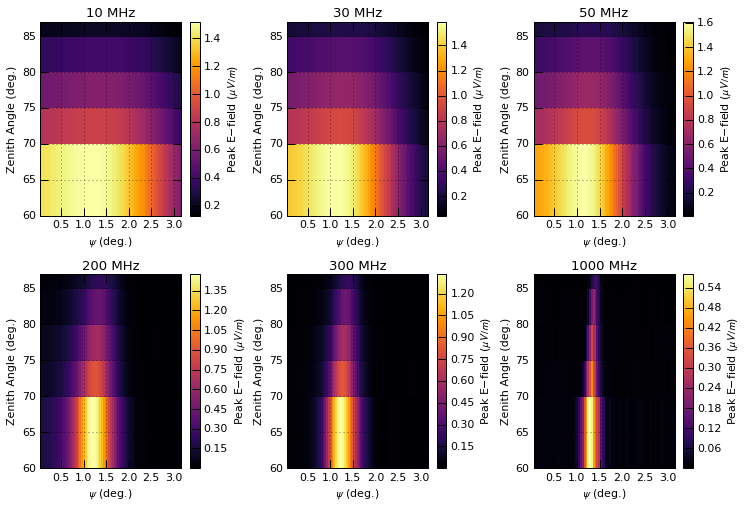

In [850]:
### First plot will be epeak vs zenith angle vs psi angle for fixed starting frequ(ency
choose_start_freq = [10., 30., 50., 200., 300., 1000.]
#ind = [np.where(f_Lo_list == choose_start_freq[i])[0][0] for i in range(len(choose_start_freq))]
ind = [1, 3, 5, 8, 20, 30]
titles = ["%d MHz"%(freq) for freq in choose_start_freq]
fig = pyp.figure(1, figsize=(12,8))
pyp.subplots_adjust(hspace=0.3, wspace=0.4)

choose_start_freq = [10., 30., 50., 200., 300., 1000.]
titles = ["%d MHz"%(freq) for freq in choose_start_freq]
fig = pyp.figure(1, figsize=(12,8))
pyp.subplots_adjust(hspace=0.3, wspace=0.4)

for i,freq in enumerate(choose_start_freq):
    i_f_Lo = int(freq/10)
    ax = pyp.subplot(2,3,i+1)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    p, zenith = np.meshgrid( psi_list, zenith_list)
    #H=epeak_array[:, ind[i_f_Lo], 0, :]*1e6
    H = epeak_start_freq_slice(i_f_Lo, epeak_array)*1e6
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    pyp.pcolormesh(p, zenith, Hmasked, cmap='inferno', )
    pyp.ylim(zenith_list.min(), zenith_list.max())
    pyp.xlim(psi_list.min(), psi_list.max())
    pyp.colorbar(label="Peak E-field ($\mu V/m$)")
    pyp.ylabel('Zenith Angle (deg.)')
    pyp.xlabel('$\psi$ (deg.)')
    pyp.grid(True, which='both')
    pyp.title(titles[i])
pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_maps_altitude%dkm_ze_vs_psi.png"%(h) )

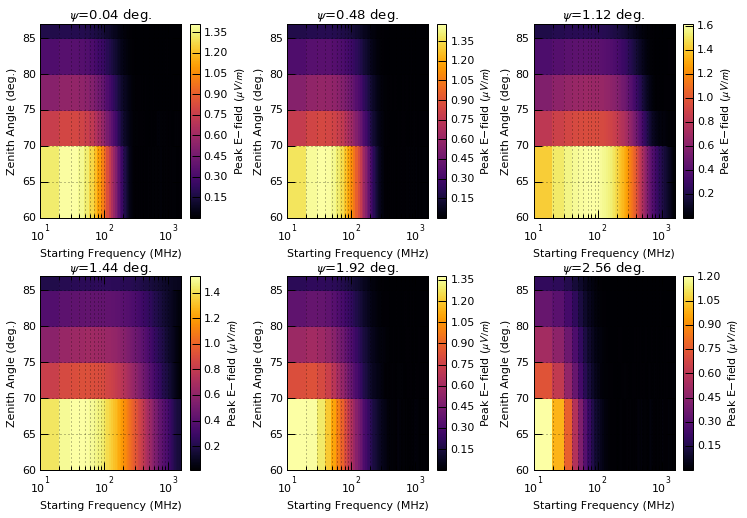

In [851]:
### Second plot will be epeak vs zenith angle vs starting frequency for fixed psi angle
ind = [0, 11, 27, 35, 47, 63]
choose_psi = psi_list[ind]
titles = ["$\psi$=%2.2f deg."%(p) for p in choose_psi]
fig = pyp.figure(1, figsize=(12,8))
pyp.subplots_adjust(hspace=0.3, wspace=0.4)

for i, p in enumerate(choose_psi):
    i_psi = ind[i]
    ax = pyp.subplot(2,3,i+1)
    ax.set_xscale('log')
    #ax.set_yscale('log')
    start_freq, zenith = np.meshgrid(  f_Lo_list, zenith_list)
    #H=epeak_array[:, :, 0, i_psi]*1e6
    H = epeak_psi_angle_slice(i_psi, epeak_array)*1e6
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    pyp.pcolormesh(start_freq, zenith, Hmasked, cmap='inferno', )
    pyp.ylim(zenith_list.min(), zenith_list.max())
    pyp.xlim(f_Lo_list.min(), f_Lo_list.max())
    pyp.colorbar(label="Peak E-field ($\mu V/m$)")
    pyp.ylabel('Zenith Angle (deg.)')
    pyp.xlabel('Starting Frequency (MHz)')
    pyp.grid(True, which='both')
    pyp.title(titles[i])
pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_maps_altitude%dkm_startfreq_vs_ze.png"%(h) )

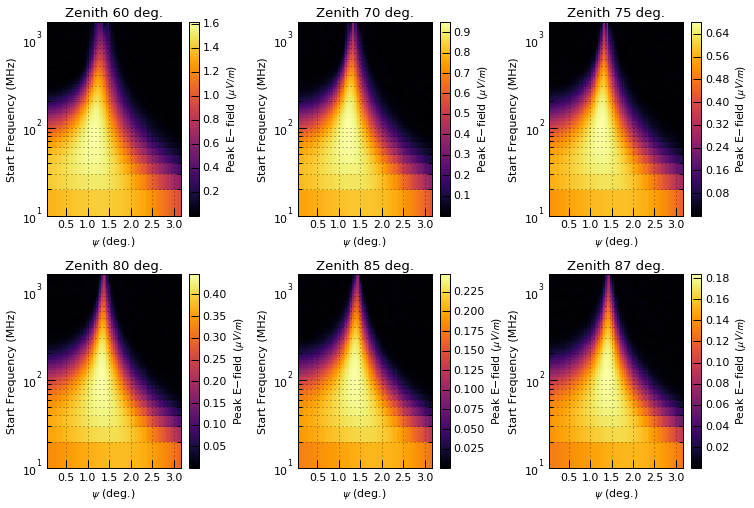

In [739]:
### Third plot will be epeak vs starting frequency vs psi_list for fixed psi angles
ind = [0,1,2,3,4,5]
choose_zenith = zenith_list[ind]
titles = ["Zenith %d deg."%(int(z)) for z in choose_zenith]
fig = pyp.figure(1, figsize=(12,8))
pyp.subplots_adjust(hspace=0.3, wspace=0.5)

for i_ze, ze in enumerate(choose_zenith):
    ax = pyp.subplot(2,3,i_ze+1)
    #ax.set_xscale('log')
    ax.set_yscale('log')
    p, start_freq = np.meshgrid(psi_list, f_Lo_list)
    #H=epeak_array[i_ze, :, 0, :]*1e6
    H = epeak_zenith_angle_slice(i_ze, epeak_array)*1e6
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    pyp.pcolormesh( p,start_freq, Hmasked, cmap='inferno', )
    pyp.xlim(psi_list.min(), psi_list.max())
    pyp.ylim(f_Lo_list.min(), f_Lo_list.max())
    pyp.colorbar(label="Peak E-field ($\mu V/m$)")
    pyp.xlabel('$\psi$ (deg.)')
    pyp.ylabel('Start Frequency (MHz)')
    pyp.grid(True, which='both')
    pyp.title(titles[i_ze])
pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_maps_altitude%dkm_startfreq_psi.png"%(h) )

In [740]:
#############
# Now look at 2d slices

In [762]:
#### This is a test of the linear interpolator in two dimensions.
### You can adjust the frequency by changing i_f_Lo, the index
### to f_Lo_list. i_f_Lo x 10 = the frequency to interpolate the 
### curvesin MHz
i_f_Lo = 30
zz,  pp = np.meshgrid(zenith_list, psi_list)
interpolator = scipy.interpolate.LinearNDInterpolator(
    np.vstack((zz.flatten(), pp.flatten())).T, 
              epeak_array[:,i_f_Lo,0,:].T.flatten()
             )  
print interpolator(75, 0.5)
print np.vstack((zz.flatten(), pp.flatten())).T[0] 

2.73094907309e-08
[  6.00000000e+01   4.00000000e-02]


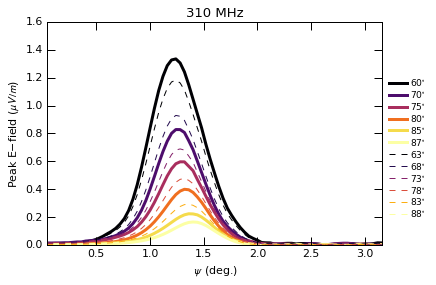

In [742]:
#### In this figure, the thick solid lines are the values from the simulatiosn
#### the dashed lines are from the interpolator.
epeak_zen = epeak_start_freq_slice(i_f_Lo, epeak_array)*1e6
norm = matplotlib.colors.Normalize(vmin=65, vmax=87)
for i_ze, ze in enumerate(zenith_list):
    pyp.plot(psi_list, epeak_zen[ i_ze, :], color = cmap(norm(ze)), linewidth=3,
             label="%d$^{\circ}$"%(int(ze)))
    
for ze in np.arange(63, 90, 5):
    pyp.plot(psi_list, interpolator( ze, psi_list,)*1e6, 
             color=cmap(norm(ze)), linestyle='--', label="%d$^{\circ}$"%(int(ze)))
pyp.xlabel(" $\psi$ (deg.)")
pyp.ylabel("Peak E-field ($\mu V/m$)")
pyp.xlim(psi_list.min(), psi_list.max())
pyp.ylim(0,)
pyp.legend(loc=[1.01, 0.1])
pyp.title("%d MHz"%((int(f_Lo_list[i_f_Lo]))))

In [743]:
#### This is a test of the linear interpolator in two dimensions.
### You can adjust the zenith angle by changing i_ze, the index
### to zenith_list. There are 6 non-uniform zenith angle bins 
### [60,70,75,80,85,87] deg. 

i_ze = 4
ff,  pp = np.meshgrid(f_Lo_list, psi_list)
interpolator = scipy.interpolate.LinearNDInterpolator(
    np.vstack((ff.flatten(), pp.flatten())).T, 
              epeak_array[i_ze,:,0,:].T.flatten()
             )  
print interpolator(600, 0.5)

2.10123122802e-09


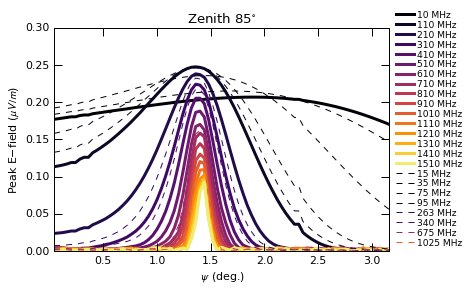

In [744]:
#### In this figure, the thick solid lines are the values from the simulatiosn
#### the dashed lines are from the interpolator.

epeak_freq = epeak_zenith_angle_slice(i_ze, epeak_array)*1e6
norm = matplotlib.colors.Normalize(vmin=10, vmax=1600)
nstep=10
for i_f_Lo, f_Lo in enumerate(f_Lo_list[0::nstep]):
    pyp.plot(psi_list, epeak_freq[ i_f_Lo*nstep, :], color = cmap(norm(f_Lo)), linewidth=3,
            label="%d MHz"%(int(f_Lo)))

for f_Lo in np.array([15, 35, 75, 95, 263, 340, 675, 1025]):
    pyp.plot(psi_list, interpolator( f_Lo, psi_list,)*1e6, 
             color=cmap(norm(f_Lo)), linestyle='--', label="%d MHz"%(int(f_Lo)))

pyp.xlim(psi_list.min(), psi_list.max())
pyp.ylim(0,)
pyp.legend(loc=[1.01, 0])
pyp.xlabel(" $\psi$ (deg.)")
pyp.ylabel("Peak E-field ($\mu V/m$)")
pyp.title("Zenith %d$^{\circ}$"%(int(zenith_list[i_ze])))

In [745]:
#### This is a test of the linear interpolator in two dimensions.
### You can adjust the psi angle by changing i_psi, the index
### to psi_list. There are 80 points in 0.04 deg spacing 
### from 0.01 to 3.2 deg. 

i_psi = 28
zz, ff = np.meshgrid(zenith_list, f_Lo_list)
interpolator = scipy.interpolate.LinearNDInterpolator(
    np.vstack((zz.flatten(), ff.flatten())).T, 
              epeak_array[:,:,0,i_psi].T.flatten()
             )  
print interpolator(63, 525)

7.45682812435e-07


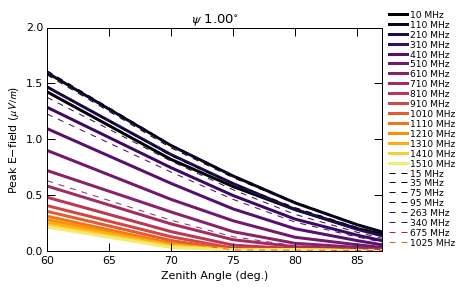

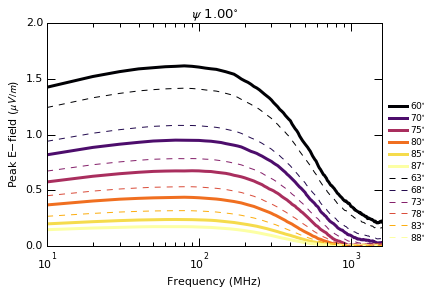

In [746]:
#### In this figure, the thick solid lines are the values from the simulatiosn
#### the dashed lines are from the interpolator.
pyp.figure(1)
epeak_psi = epeak_psi_angle_slice(i_psi, epeak_array)*1e6
norm = matplotlib.colors.Normalize(vmin=10, vmax=1600)
nstep=10
for i_f_Lo, f_Lo in enumerate(f_Lo_list[0::nstep]):
    pyp.plot(zenith_list, epeak_psi[ :, i_f_Lo*nstep], color = cmap(norm(f_Lo)), linewidth=3,
            label="%d MHz"%(int(f_Lo)))

for f_Lo in np.array([15, 35, 75, 95, 263, 340, 675, 1025]):
    pyp.plot(zenith_list, interpolator(zenith_list, f_Lo)*1e6, 
             color=cmap(norm(f_Lo)), linestyle='--', label="%d MHz"%(int(f_Lo)))    

pyp.xlim(zenith_list.min(), zenith_list.max())
pyp.ylim(0,)
pyp.xlabel("Zenith Angle (deg.)")
pyp.ylabel("Peak E-field ($\mu V/m$)")
pyp.legend(loc=[1.01, 0.])
pyp.title("$\psi$ %2.2f$^{\circ}$"%(int(psi_list[i_psi])))

pyp.figure(2)
epeak_zen = epeak_array[:,:,0,i_psi]*1e6
norm = matplotlib.colors.Normalize(vmin=65, vmax=87)
for i_ze, ze in enumerate(zenith_list):
    pyp.semilogx(f_Lo_list, epeak_zen[ i_ze, :], color = cmap(norm(ze)), linewidth=3,
             label="%d$^{\circ}$"%(int(ze)))
    
for ze in np.arange(63, 90, 5):
    pyp.semilogx(f_Lo_list, interpolator( ze, f_Lo_list)*1e6, 
             color=cmap(norm(ze)), linestyle='--', label="%d$^{\circ}$"%(int(ze)))
    
pyp.xlim(f_Lo_list.min(), f_Lo_list.max())
pyp.ylim(0,)
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("Peak E-field ($\mu V/m$)")
pyp.legend(loc=[1.01, 0.])
pyp.title("$\psi$ %2.2f$^{\circ}$"%(int(psi_list[i_psi])))

In [747]:
##############
## Now interpolate in all three dimensions

In [819]:
#### This is a test of the linear interpolator in three dimensions.
points = []
values = []
c=0
for i_z,z in enumerate(zenith_list):
    for i_f,f in enumerate(f_Lo_list):
        for i_p,p in enumerate(psi_list):
            points.append( [z,f,p] )
            values.append(epeak_array[i_z, i_f, 0, i_p])

interpolator = scipy.interpolate.LinearNDInterpolator(points, values)
print interpolator(63, 32, 0.5)

1.29314268324e-06


5 87
6 70.0


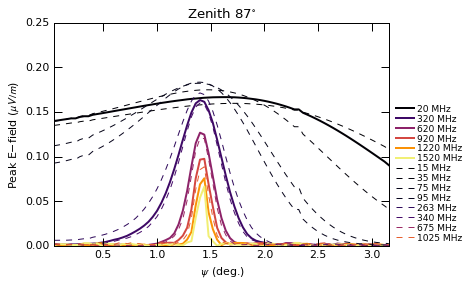

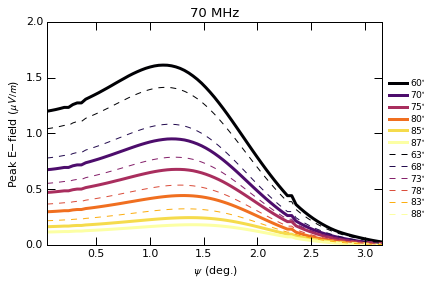

In [871]:
i_ze = 5
i_f_Lo = 6
print i_ze, zenith_list[i_ze]
print i_f_Lo, f_Lo_list[i_f_Lo]
pyp.figure(1)
epeak_zen = epeak_zenith_angle_slice(i_ze, epeak_array)*1e6
norm = matplotlib.colors.Normalize(vmin=10, vmax=1600)
for f_Lo in range(1, 160, 30):
    pyp.plot(psi_list, epeak_zen[ f_Lo, :], color = cmap(norm(f_Lo_list[f_Lo])), linewidth=2,
            label="%d MHz"%(int(f_Lo_list[f_Lo])))
    #pyp.plot(psi_list, interpolator(87, f_Lo_list[i_f_Lo], psi_list)*1e6, color = cmap(norm(i_f_Lo)), linewidth=2)

    
for f_Lo in np.array([15, 35, 75, 95, 263, 340, 675, 1025]):
    pyp.plot(psi_list, interpolator(zenith_list[i_ze], f_Lo, psi_list)*1e6, 
             color=cmap(norm(f_Lo)), linestyle='--', label="%d MHz"%(int(f_Lo)))   
pyp.legend(loc=[1.01,0])
pyp.xlabel(" $\psi$ (deg.)")
pyp.ylabel("Peak E-field ($\mu V/m$)")
pyp.xlim(psi_list.min(), psi_list.max())
pyp.ylim(0,)
pyp.title("Zenith %d$^{\circ}$"%(int(zenith_list[i_ze])))
pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/3dinterp_efield_maps_altitude%dkm_psi_ze%d.png"%(h, int(zenith_list[i_ze], )) )

pyp.figure(2)
epeak_zen = epeak_start_freq_slice(i_f_Lo, epeak_array)*1e6
norm = matplotlib.colors.Normalize(vmin=65, vmax=87)
for i_ze, ze in enumerate(zenith_list):
    pyp.plot(psi_list, epeak_zen[ i_ze, :], color = cmap(norm(ze)), linewidth=3,
             label="%d$^{\circ}$"%(int(ze)))
    
for ze in np.arange(63, 90, 5):
    pyp.plot(psi_list, interpolator( ze, f_Lo_list[i_f_Lo], psi_list,)*1e6, 
             color=cmap(norm(ze)), linestyle='--', label="%d$^{\circ}$"%(int(ze)))
pyp.xlabel(" $\psi$ (deg.)")
pyp.ylabel("Peak E-field ($\mu V/m$)")
pyp.xlim(psi_list.min(), psi_list.max())
pyp.ylim(0,)
pyp.legend(loc=[1.01, 0.1])
pyp.title("%d MHz"%((int(f_Lo_list[i_f_Lo]))))
pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/3dinterp_efield_maps_altitude%dkm_psi_fLo%dMHz.png"%(h, int(f_Lo_list[i_f_Lo]))) 

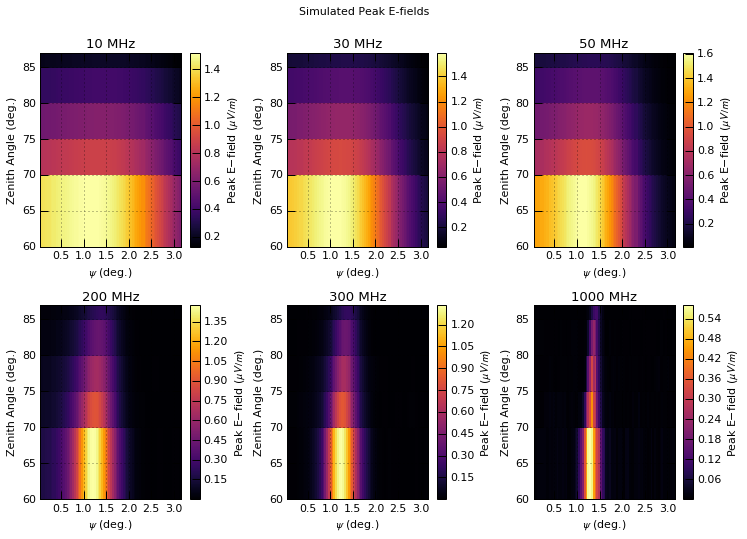

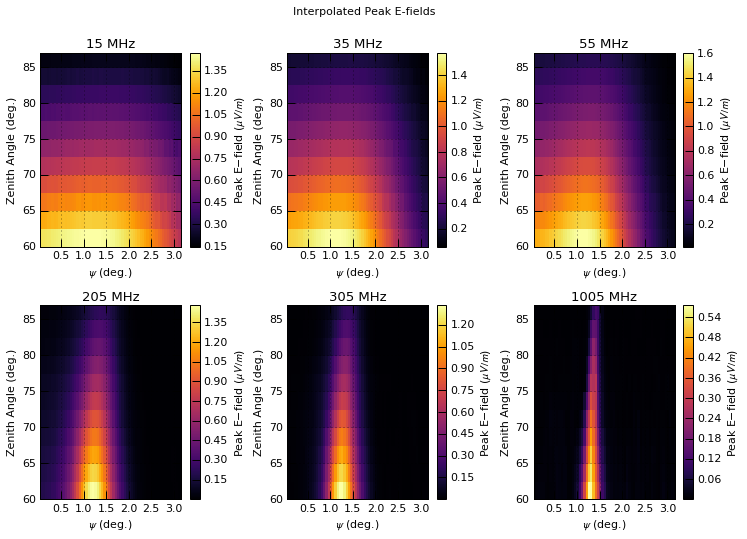

In [872]:
###########
# Now check the 2D slices 
# comparing the original values
# to the interpolated values
### First plot will be epeak vs zenith angle vs psi angle for fixed starting frequ(ency
choose_start_freq = [10., 30., 50., 200., 300., 1000.]
titles = ["%d MHz"%(freq) for freq in choose_start_freq]
fig = pyp.figure(1, figsize=(12,8))
pyp.subplots_adjust(hspace=0.3, wspace=0.4)

for i,freq in enumerate(choose_start_freq):
    i_f_Lo = int(freq/10)
    ax = pyp.subplot(2,3,i+1)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    p, zenith = np.meshgrid( psi_list, zenith_list)
    #H=epeak_array[:, ind[i_f_Lo], 0, :]*1e6
    H = epeak_start_freq_slice(i_f_Lo, epeak_array)*1e6
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    pyp.pcolormesh(p, zenith, Hmasked, cmap='inferno', )
    pyp.ylim(zenith_list.min(), zenith_list.max())
    pyp.xlim(psi_list.min(), psi_list.max())
    pyp.colorbar(label="Peak E-field ($\mu V/m$)")
    pyp.ylabel('Zenith Angle (deg.)')
    pyp.xlabel('$\psi$ (deg.)')
    pyp.grid(True, which='both')
    pyp.title(titles[i])
pyp.suptitle("Simulated Peak E-fields")
#pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_maps_altitude%dkm_ze_vs_psi.png"%(h) )

choose_start_freq = [15., 35., 55., 205., 305., 1005.]
#ind = [np.where(f_Lo_list == choose_start_freq[i])[0][0] for i in range(len(choose_start_freq))]
ind = [1, 3, 5, 8, 20, 30]
titles = ["%d MHz"%(freq) for freq in choose_start_freq]
fig = pyp.figure(2, figsize=(12,8))
pyp.subplots_adjust(hspace=0.3, wspace=0.4)

interp_psi_list = np.arange(0.05, 3.2, 0.05)
interp_zenith_list = np.arange(60, 90, 2.5)
for i_f_Lo, freq in enumerate(choose_start_freq):
    ax = pyp.subplot(2,3,i_f_Lo+1)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    p, zenith = np.meshgrid( interp_psi_list, interp_zenith_list)
    H = interpolator(zenith, freq, p)*1e6
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    pyp.pcolormesh(p, zenith, Hmasked, cmap='inferno', )
    pyp.ylim(zenith_list.min(), zenith_list.max())
    pyp.xlim(psi_list.min(), psi_list.max())
    pyp.colorbar(label="Peak E-field ($\mu V/m$)")
    pyp.ylabel('Zenith Angle (deg.)')
    pyp.xlabel('$\psi$ (deg.)')
    pyp.grid(True, which='both')
    pyp.title(titles[i_f_Lo])
pyp.suptitle("Interpolated Peak E-fields")
pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/interp_efield_maps_altitude%dkm_ze_vs_psi.png"%(h) )

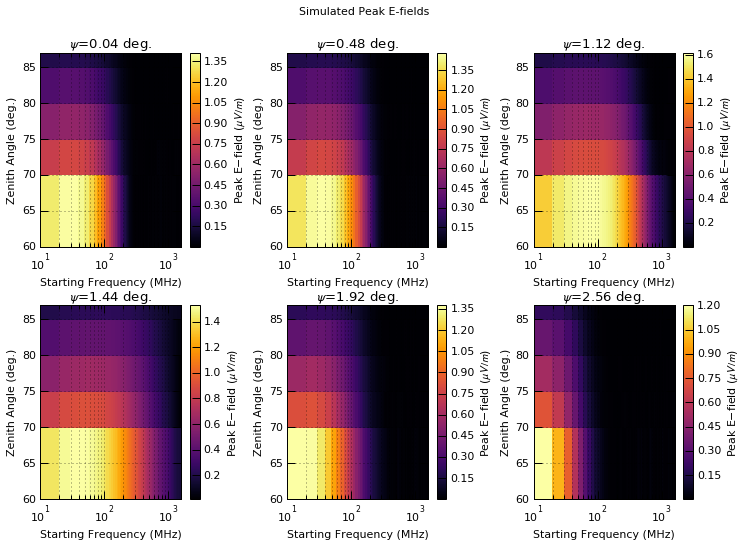

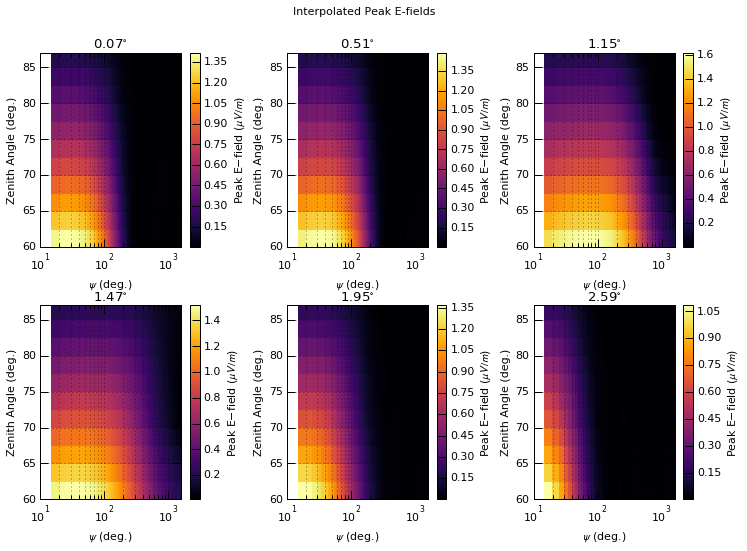

In [873]:
### Second plot will be epeak vs zenith angle vs starting frequency for fixed psi angle
ind = [0, 11, 27, 35, 47, 63]
choose_psi = psi_list[ind]
titles = ["$\psi$=%2.2f deg."%(p) for p in choose_psi]
fig = pyp.figure(1, figsize=(12,8))
pyp.subplots_adjust(hspace=0.3, wspace=0.4)

for i, p in enumerate(choose_psi):
    i_psi = ind[i]
    ax = pyp.subplot(2,3,i+1)
    ax.set_xscale('log')
    #ax.set_yscale('log')
    start_freq, zenith = np.meshgrid(  f_Lo_list, zenith_list)
    #H=epeak_array[:, :, 0, i_psi]*1e6
    H = epeak_psi_angle_slice(i_psi, epeak_array)*1e6
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    pyp.pcolormesh(start_freq, zenith, Hmasked, cmap='inferno', )
    pyp.ylim(zenith_list.min(), zenith_list.max())
    pyp.xlim(f_Lo_list.min(), f_Lo_list.max())
    pyp.colorbar(label="Peak E-field ($\mu V/m$)")
    pyp.ylabel('Zenith Angle (deg.)')
    pyp.xlabel('Starting Frequency (MHz)')
    pyp.grid(True, which='both')
    pyp.title(titles[i])
pyp.suptitle("Simulated Peak E-fields")


#pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_maps_altitude%dkm_startfreq_vs_ze.png"%(h) )
choose_psi = [p + 0.03 for p in choose_psi]
titles = ["%2.2f$^{\circ}$"%(p) for p in choose_psi]
fig = pyp.figure(2, figsize=(12,8))
pyp.subplots_adjust(hspace=0.3, wspace=0.4)

interp_freq_list = np.arange(15, 1600, 5)
interp_zenith_list = np.arange(60, 90, 2.5)
for i_psi, psi in enumerate(choose_psi):
    ax = pyp.subplot(2,3,i_psi+1)
    ax.set_xscale('log')
    #ax.set_yscale('log')
    freq, zenith = np.meshgrid( interp_freq_list, interp_zenith_list)
    H = interpolator(zenith, freq, psi)*1e6
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    pyp.pcolormesh(freq, zenith, Hmasked, cmap='inferno', )
    pyp.ylim(zenith_list.min(), zenith_list.max())
    pyp.xlim(f_Lo_list.min(), f_Lo_list.max())
    pyp.colorbar(label="Peak E-field ($\mu V/m$)")
    pyp.ylabel('Zenith Angle (deg.)')
    pyp.xlabel('$\psi$ (deg.)')
    pyp.grid(True, which='both')
    pyp.title(titles[i_psi])
pyp.suptitle("Interpolated Peak E-fields")
pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/interp_efield_maps_altitude%dkm_startfreq_vs_ze.png"%(h) )

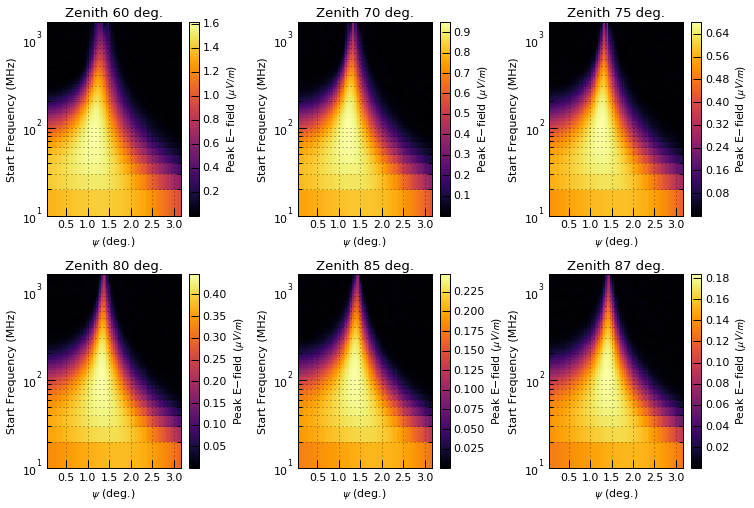

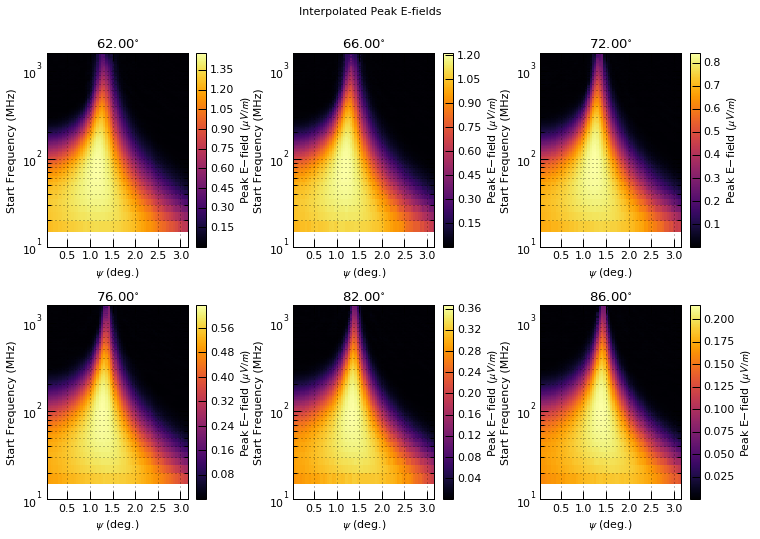

In [874]:
### Third plot will be epeak vs starting frequency vs psi_list for fixed psi angles
ind = [0,1,2,3,4,5]
choose_zenith = zenith_list[ind]
titles = ["Zenith %d deg."%(int(z)) for z in choose_zenith]
fig = pyp.figure(1, figsize=(12,8))
pyp.subplots_adjust(hspace=0.3, wspace=0.5)

for i_ze, ze in enumerate(choose_zenith):
    ax = pyp.subplot(2,3,i_ze+1)
    #ax.set_xscale('log')
    ax.set_yscale('log')
    p, start_freq = np.meshgrid(psi_list, f_Lo_list)
    #H=epeak_array[i_ze, :, 0, :]*1e6
    H = epeak_zenith_angle_slice(i_ze, epeak_array)*1e6
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    pyp.pcolormesh( p,start_freq, Hmasked, cmap='inferno', )
    pyp.xlim(psi_list.min(), psi_list.max())
    pyp.ylim(f_Lo_list.min(), f_Lo_list.max())
    pyp.colorbar(label="Peak E-field ($\mu V/m$)")
    pyp.xlabel('$\psi$ (deg.)')
    pyp.ylabel('Start Frequency (MHz)')
    pyp.grid(True, which='both')
    pyp.title(titles[i_ze])
#pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/efield_maps_altitude%dkm_startfreq_psi.png"%(h) )

choose_zenith = [62, 66, 72, 76, 82, 86 ]
titles = ["%2.2f$^{\circ}$"%(z) for z in choose_zenith]
fig = pyp.figure(2, figsize=(12,8))
pyp.subplots_adjust(hspace=0.3, wspace=0.4)

interp_freq_list = np.arange(15, 1600, 5)
interp_psi_list = np.arange(0.05, 3.2, 0.05)
for i_ze, ze in enumerate(choose_zenith):
    ax = pyp.subplot(2,3,i_ze+1)
    #ax.set_xscale('log')
    ax.set_yscale('log')
    psi, freq = np.meshgrid( interp_psi_list, interp_freq_list)
    H = interpolator(ze, freq, psi)*1e6
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    pyp.pcolormesh(psi, freq, Hmasked, cmap='inferno', )
    pyp.xlim(psi_list.min(), psi_list.max())
    pyp.ylim(f_Lo_list.min(), f_Lo_list.max())
    pyp.colorbar(label="Peak E-field ($\mu V/m$)")
    pyp.xlabel('$\psi$ (deg.)')
    pyp.ylabel('Start Frequency (MHz)')
    pyp.grid(True, which='both')
    pyp.title(titles[i_ze])
pyp.suptitle("Interpolated Peak E-fields")
pyp.savefig(os.environ['TAU_ACC_DETECTOR_PLOTS_DIR'] + "/interp_efield_maps_altitude%dkm_startfreq_psi.png"%(h) )

In [877]:
################
def save_interpolator(interpolator, h):
	interp_file = open(os.environ['TAU_ACC_ZHAIRES_DIR']\
                       +'/interpolator_efields_%dkm.npz'%h, 'w')
	np.savez(interp_file, efield_interpolator=interpolator)
	interp_file.close()

In [876]:
save_interpolator(interpolator, h)

In [886]:
def load_interpolator(h):
    # the interpolator is for 10-MHz subbands and 
    # is called as interpolator(zenith_angle, starting_frequency,psi_angle)
    # zenith angle is the shower zenith angle in deg.
    # staring_frequency is the lowest frequency in the band in MHz
    # psi_angle is the angel off the shower axis, 
    # equivalent to view angle in deg.
    interp_file = np.load(os.environ['TAU_ACC_ZHAIRES_DIR']\
                       +'/interpolator_efields_%dkm.npz'%h)
    return interp_file['efield_interpolator'][()]

In [888]:
interpolator = load_interpolator(37)

In [892]:
print interpolator(70, 400, 0.06)

6.85985637334e-09
